In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, kpss
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import warnings
warnings.filterwarnings("ignore")

In [34]:
data=pd.read_csv("Movements of Australia's east coast humpback whales.csv")
print(data.shape)

datetime_col=next((c for c in data.columns if 'time' in c.lower() or 'date' in c.lower()),None)
lat_col=next((c for c in data.columns if 'lat' in c.lower()), None)
lon_col=next((c for c in data.columns if any(x in c.lower() for x in ['lon','long','lng'])),None)

if not datetime_col:
    raise ValueError("No datetime-like column found!")

# Clean and prepare data
data[datetime_col]=pd.to_datetime(data[datetime_col],errors='coerce')
data=data.dropna(subset=[datetime_col])
data=data.sort_values(by=datetime_col)
data.set_index(datetime_col, inplace=True)

#Aggregate daily data
daily=pd.DataFrame()
daily["count"]=data.index.to_series().groupby(data.index.date).size()
daily.index=pd.to_datetime(daily.index)

if lat_col and lon_col:
    daily["mean_lat"]=data[lat_col].resample("D").mean().interpolate()
    daily["mean_lon"]=data[lon_col].resample("D").mean().interpolate()

#Aggregate monthly
monthly = daily.resample("M").agg({'count':'sum','mean_lat':'mean','mean_lon':'mean'})
print(f"Date range: {monthly.index.min().date()} to {monthly.index.max().date()}")
print("Total months:", len(monthly))

(30388, 19)
Date range: 2008-10-31 to 2011-07-31
Total months: 34


In [35]:
# Stationarity Tests
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest=adfuller(timeseries.dropna(),autolag="AIC")
    dfoutput=pd.Series(dftest[0:4], index=["Test Statistic","p-value","#Lags Used","Observations Used"])
    for key,value in dftest[4].items():
        dfoutput[f"Critical Value ({key})"]=value
    print(dfoutput)
    if dfoutput["p-value"]<=0.05:
        print("ADF: Data is likely stationary (reject H0).")
    else:
        print("ADF: Data is non-stationary (fail to reject H0).")

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest=kpss(timeseries.dropna(),regression="c",nlags="auto")
    kpss_output=pd.Series(kpsstest[0:3], index=["Test Statistic","p-value","Lags Used"])
    print(kpss_output)
    if kpss_output["p-value"]<=0.05:
        print("KPSS: Data is non-stationary (reject H0).")
    else:
        print("KPSS: Data is stationary (fail to reject H0).")

adf_test(monthly["count"])
print()
kpss_test(monthly["count"])

Results of Dickey-Fuller Test:
Test Statistic          -3.030257
p-value                  0.032164
#Lags Used               0.000000
Observations Used       33.000000
Critical Value (1%)     -3.646135
Critical Value (5%)     -2.954127
Critical Value (10%)    -2.615968
dtype: float64
ADF: Data is likely stationary (reject H0).

Results of KPSS Test:
Test Statistic    0.299522
p-value           0.100000
Lags Used         2.000000
dtype: float64
KPSS: Data is stationary (fail to reject H0).


<Figure size 1500x600 with 0 Axes>

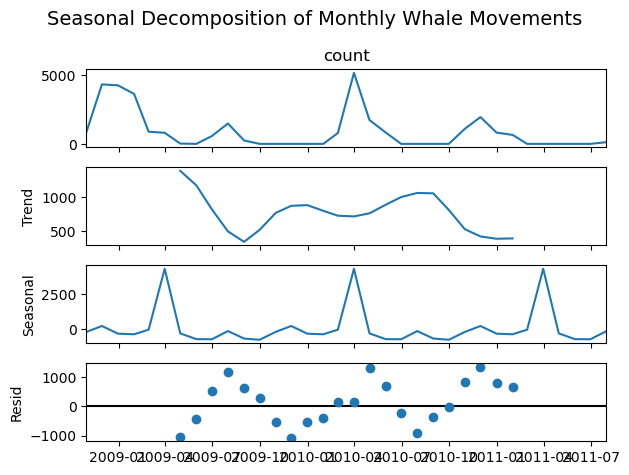

In [36]:
#Seasonal Decomposition 
if len(monthly)>=24:
    plt.figure(figsize=(15,6))
    decomposition=seasonal_decompose(monthly["count"],model="additive",period=12)
    decomposition.plot()
    plt.suptitle("Seasonal Decomposition of Monthly Whale Movements",fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("Not enough months for reliable seasonal decomposition (<24 months).")

In [37]:
# BY KPSS AND ADF TEST WE SAY THAT THE DATA IS STATIONARY
counts=monthly["count"].replace(0, np.nan).dropna()
transformed,lam=boxcox(counts)

# Exponential smoothing

In [38]:
data=monthly["count"].astype(float).dropna()
train_size=int(len(data)*0.8)
train,test=data.iloc[:train_size],data.iloc[train_size:]

In [39]:
model=ExponentialSmoothing(data,trend="add",seasonal="add",seasonal_periods=12)
fit=model.fit(optimized=True)

In [40]:
forecast_horizon=len(test)+12
forecast=fit.forecast(forecast_horizon)

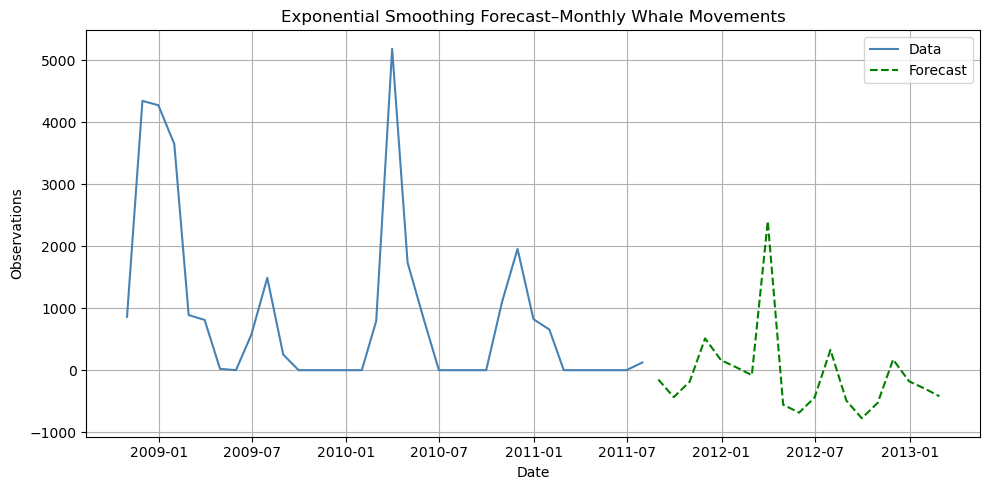

In [41]:
plt.figure(figsize=(10,5))
plt.plot(data.index,data,label="Data",color="steelblue")
plt.plot(forecast.index,forecast,label="Forecast",color="green",linestyle="--")
plt.title("Exponential Smoothing Forecast–Monthly Whale Movements")
plt.xlabel("Date")
plt.ylabel("Observations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ARIMA

In [42]:
data=monthly["count"].astype(float).dropna()
train_size=int(len(data)*0.8)
train,test=data.iloc[:train_size],data.iloc[train_size:]
data-data.shift()

2008-10-31       NaN
2008-11-30    3484.0
2008-12-31     -71.0
2009-01-31    -626.0
2009-02-28   -2760.0
2009-03-31     -78.0
2009-04-30    -789.0
2009-05-31     -22.0
2009-06-30     574.0
2009-07-31     916.0
2009-08-31   -1239.0
2009-09-30    -251.0
2009-10-31       0.0
2009-11-30       0.0
2009-12-31       0.0
2010-01-31       0.0
2010-02-28     795.0
2010-03-31    4391.0
2010-04-30   -3450.0
2010-05-31    -898.0
2010-06-30    -838.0
2010-07-31       0.0
2010-08-31       0.0
2010-09-30       0.0
2010-10-31    1105.0
2010-11-30     852.0
2010-12-31   -1134.0
2011-01-31    -168.0
2011-02-28    -655.0
2011-03-31       0.0
2011-04-30       0.0
2011-05-31       0.0
2011-06-30       0.0
2011-07-31     124.0
Freq: ME, Name: count, dtype: float64

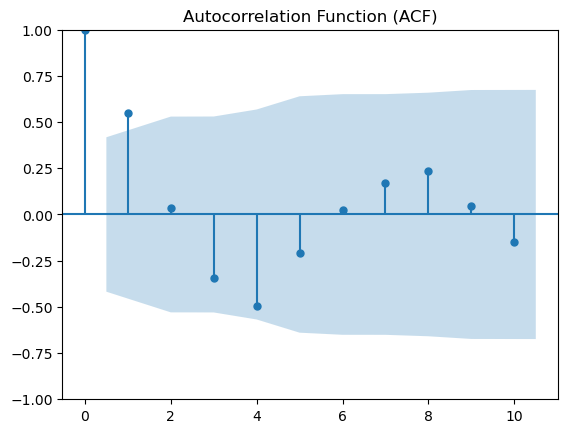

In [43]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf((data-data.shift(12)).dropna(),lags=10,title='Autocorrelation Function (ACF)')
plt.show()

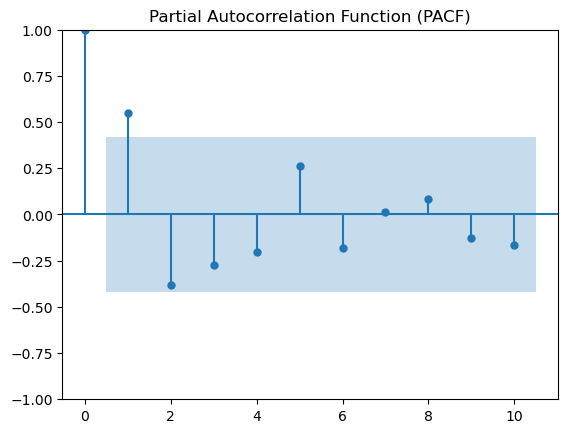

In [44]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf((data-data.shift(12)).dropna(),lags=10,title='Partial Autocorrelation Function (PACF)')
plt.show()

In [45]:
model=SARIMAX(data,order=(1,1,1),enforce_stationarity=False,enforce_invertibility=False)
fit=model.fit(disp=False)
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  count   No. Observations:                   34
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -263.419
Date:                Thu, 01 Jan 2026   AIC                            532.838
Time:                        20:06:46   BIC                            537.140
Sample:                    10-31-2008   HQIC                           534.240
                         - 07-31-2011                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4507      0.201      2.237      0.025       0.056       0.846
ma.L1         -1.1009      0.324     -3.397      0.001      -1.736      -0.466
sigma2      1.328e+06   4.45e+05      2.985      0.003    4.56e+05     2.2e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               144.82
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                             2.42
Prob(H) (two-sided):                  0.02   Kurtosis:                        12.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
forecast_horizon=len(test)+12  
forecast=fit.forecast(forecast_horizon)

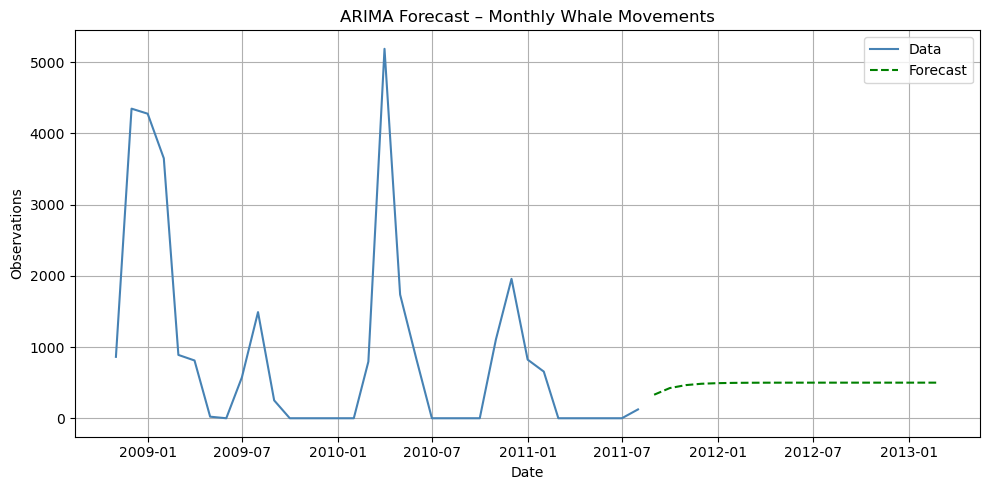

In [47]:
plt.figure(figsize=(10,5))
plt.plot(data.index,data,label="Data",color="steelblue")
plt.plot(forecast.index,forecast,label="Forecast",color="green",linestyle="--")
plt.title("ARIMA Forecast – Monthly Whale Movements")
plt.xlabel("Date")
plt.ylabel("Observations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# SARIMA

In [48]:
data=monthly["count"].astype(float).dropna()
train_size=int(len(data)*0.8)
train,test=data.iloc[:train_size],data.iloc[train_size:]

In [49]:
model=SARIMAX(transformed,order=(0,0,0),seasonal_order=(1,1,1,12))
result=model.fit(disp=False)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:                          y   No. Observations:                   19
Model:             SARIMAX(1, 1, [1], 12)   Log Likelihood                 -24.394
Date:                    Thu, 01 Jan 2026   AIC                             54.789
Time:                            20:06:47   BIC                             54.626
Sample:                                 0   HQIC                            52.783
                                     - 19                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.7490   6781.747     -0.000      1.000   -1.33e+04    1.33e+04
ma.S.L12      -0.5496   2.17e+04  -2.54e-05      1.000   -4.24e+04    4.24e+04
sigma2        12.8598   2360.770      0.005      0.996   -4614.164    4639.884
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                 0.59
Prob(Q):                              0.73   Prob(JB):                         0.74
Heteroskedasticity (H):               0.13   Skew:                            -0.24
Prob(H) (two-sided):                  0.24   Kurtosis:                         1.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.75e+18. Standard errors may be unstable.
"""

In [50]:
forecast_steps=len(test)+12
forecast_transformed=result.forecast(steps=forecast_steps)
forecast=inv_boxcox(forecast_transformed, lam)
forecast_index=pd.date_range(counts.index[-1]+pd.offsets.MonthBegin(1),periods=forecast_steps,freq="M")
forecast_df=pd.DataFrame({"forecast_count":forecast},index=forecast_index)

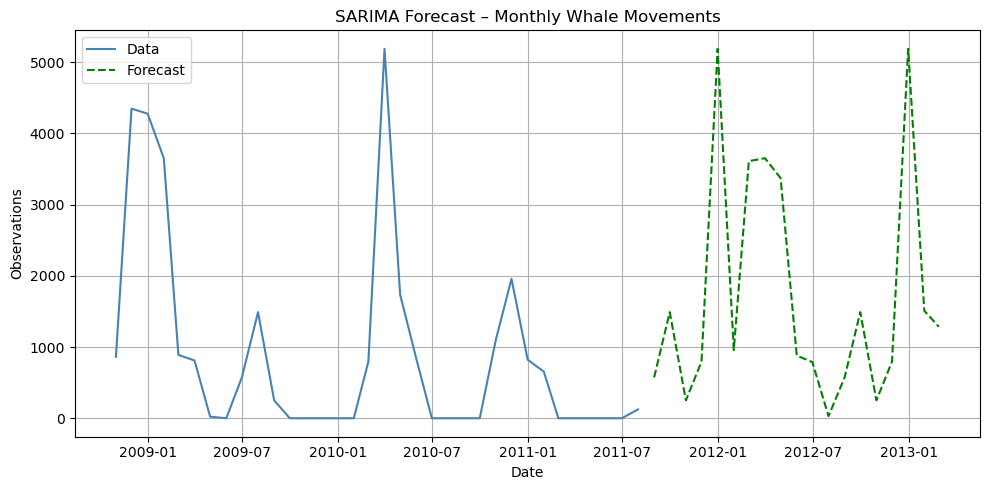

In [51]:
plt.figure(figsize=(10,5))
plt.plot(data.index,data,label="Data",color="steelblue")
plt.plot(forecast_df.index,forecast,label="Forecast",color="green",linestyle="--")
plt.title("SARIMA Forecast – Monthly Whale Movements")
plt.xlabel("Date")
plt.ylabel("Observations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

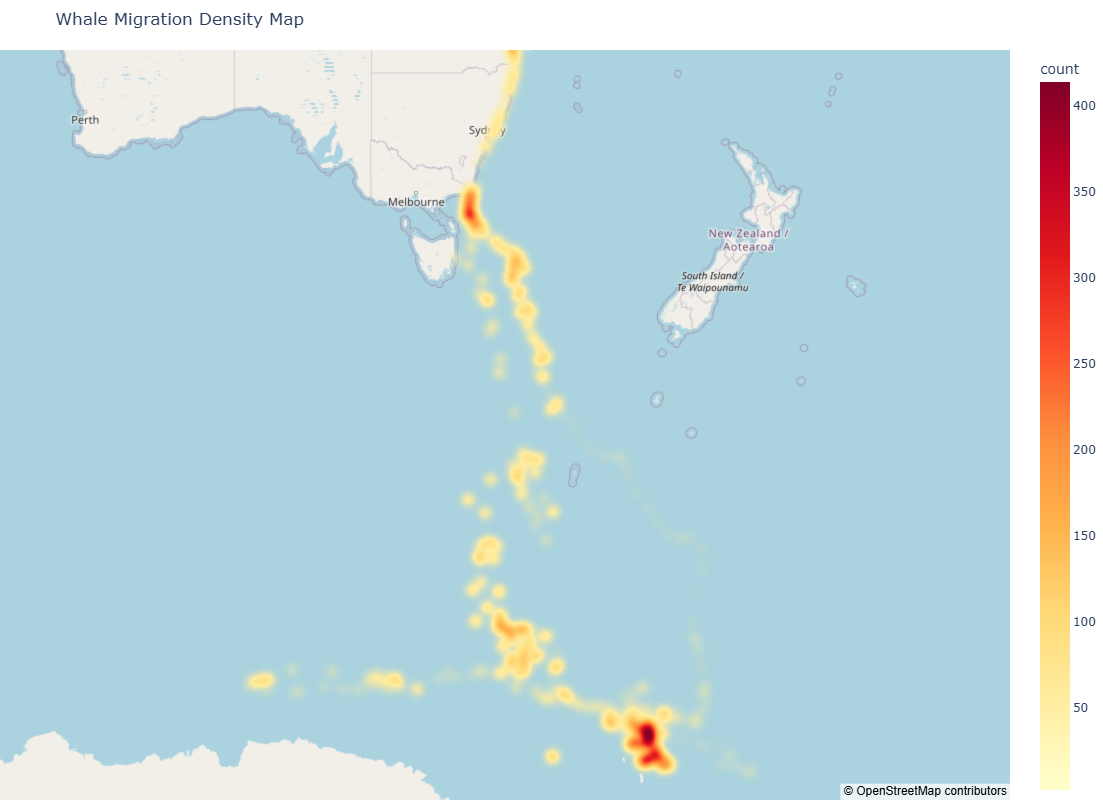

In [52]:
import plotly.express as px

valid=daily.dropna(subset=["mean_lat", "mean_lon"])

valid["count"]=valid.get("count", 1)
fig=px.density_mapbox(valid,lat="mean_lat",lon="mean_lon",z="count",        
    radius=15,center=dict(lat=valid["mean_lat"].mean(), lon=valid["mean_lon"].mean()),zoom=3,
    mapbox_style="open-street-map",color_continuous_scale="YlOrRd",title="Whale Migration Density Map")
fig.update_layout(height=800, margin=dict(r=0, t=50, l=0, b=0))
fig.show()